In [35]:
from products.snow_cover_product import MeteoFranceSNPPPrototype, VNP10A1, VJ110A1

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/'
product_list = [ VNP10A1(), VJ110A1(), MeteoFranceSNPPPrototype()]


In [36]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import line_plot_rmse, plot_custom_spans
import matplotlib.patches as mpatches
from postprocess.general_purpose import open_reduced_dataset_for_plot
from postprocess.skill_scores import line_plot_accuracy_f1_score, line_plot_total_count
from products.snow_cover_product import SnowCoverProduct
import xarray as xr



def plot_product_legend(snow_cover_products: List[SnowCoverProduct],legend_ax: Axes):
    custom_leg = [
            mpatches.Patch(color=product.plot_color, label=product.plot_name)
            for product in snow_cover_products
        ]
        
    product_legend =legend_ax.legend(handles=custom_leg, loc=(1,0))
    legend_ax.add_artist(product_legend)

def plot_one_var_analysis(snow_cover_products: List[SnowCoverProduct],analysis_folder: str, analysis_var:str, axs: List[Axes]):
        line_plot_accuracy_f1_score(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var,ax=axs[0])
        line_plot_rmse(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var,ax=axs[1])
        plot_custom_spans(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder,analysis_var=analysis_var, ax=axs[2])
        line_plot_total_count(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder,analysis_var=analysis_var, ax=axs[-1])
def plot_grid(snow_cover_products: List[SnowCoverProduct],analysis_folder: str, params_list:List[str], axs: List[Axes]):
    for i, var in enumerate(params_list):
        if var=="View Zenith Angle [°]":
            plot_one_var_analysis(snow_cover_products=snow_cover_products, 
                                  analysis_folder=analysis_folder,
                                  analysis_var=var,
                                  axs=axs[i])
        else:
            plot_one_var_analysis(snow_cover_products, analysis_folder, var,axs[i])



<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_23516/2967922139.py:5: SyntaxWarning: invalid escape sequence '\%'
  params = ["Ref FSC [\%]","Aspect", "Landcover", "Slope [°]"]


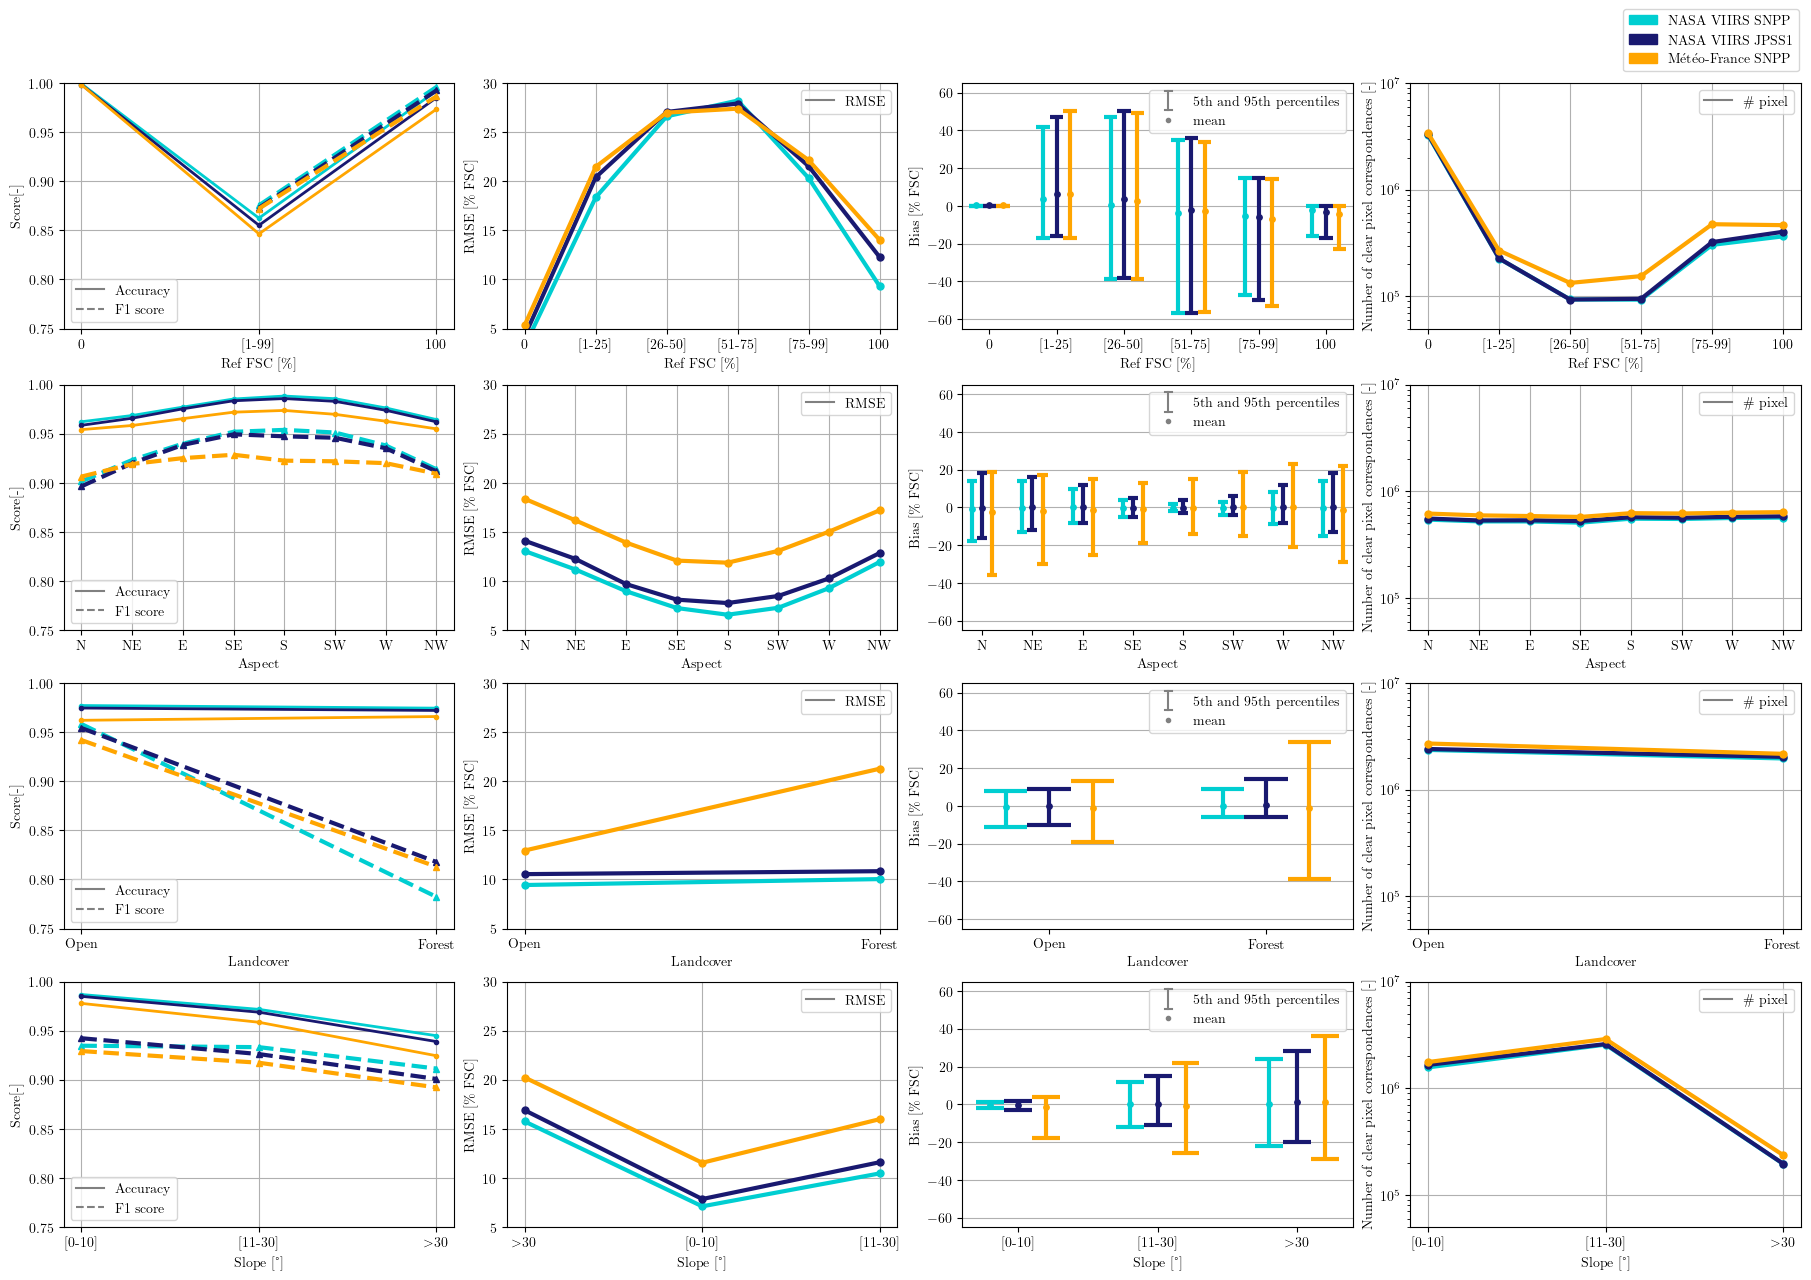

In [39]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
params = ["Ref FSC [\%]","Aspect", "Landcover", "Slope [°]"] 
fig, axs = plt.subplots(len(params), 4, figsize=(18,3  * len(params)), layout="constrained")
plot_grid(snow_cover_products=product_list,analysis_folder=analysis_folder,params_list=params, axs=axs)
# plot_product_legend(snow_cover_products=product_list, legend_ax=axs[0,1])
custom_leg = [
        mpatches.Patch(color=product.plot_color, label=product.plot_name)
        for product in product_list
    ]
fig.legend(handles=custom_leg, bbox_to_anchor=(1,1.06))
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/synthesis_scores_plot.png', format='png',bbox_inches='tight')

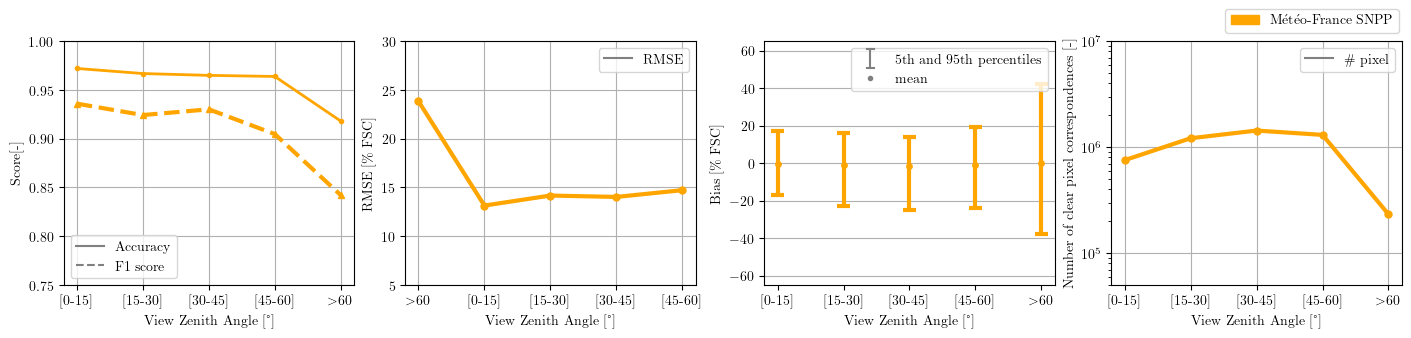

In [40]:
from products.snow_cover_product import MeteoFranceSNPPPrototype
from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8_sensor_zenith/'
product_list = [ MeteoFranceSNPPPrototype()]
params = ["View Zenith Angle [°]"] 
fig, axs = plt.subplots(len(params), 4, figsize=(14,3  * len(params)), layout="constrained")
plot_one_var_analysis(snow_cover_products=product_list,analysis_folder=analysis_folder,analysis_var=params[0], axs=axs)
# plot_product_legend(snow_cover_products=product_list, legend_ax=axs[1]) 

custom_leg = [
        mpatches.Patch(color=product.plot_color, label=product.plot_name)
        for product in product_list
    ]
# product_legend =legend_ax.legend(handles=custom_leg, loc=(1,0))
fig.legend(handles=custom_leg, bbox_to_anchor=(1,1.1))
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/synthesis_scores_plot_sza.png', format='png',bbox_inches='tight')

In [3]:
from typing import List

import numpy as np
from matplotlib import patches, ticker
from matplotlib.axes import Axes

from postprocess.error_distribution import postprocess_uncertainty_analysis
from postprocess.general_purpose import open_reduced_dataset, open_reduced_dataset_completeness, open_reduced_dataset_for_plot
from products.snow_cover_product import SnowCoverProduct


def annual_area_fancy_plot(
    snow_cover_products: List[SnowCoverProduct],
    analysis_folder: str,
    axs: List[Axes] | None = None,
):
    [ax.set_ylabel("Area [km²]") for ax in axs[:1]]
    axs[1].set_ylabel("RMSE [\% FSC]")
    custom_leg = [patches.Patch(color=product.plot_color, label=product.plot_name) for product in snow_cover_products]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.45])
    axs[0].add_artist(product_legend)
    for product in snow_cover_products:
        metrics_dataset_completeness = open_reduced_dataset_completeness(product=product, analysis_folder=analysis_folder).sel(
            time=slice("2023-11", "2024-06"), altitude_bins=slice(900, None)
        )
        product_monthly_averages = (
            metrics_dataset_completeness.resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        product_monthly_averages = product_monthly_averages.sum(
            dim=[d for d in product_monthly_averages.dims if d != "time" and d != "class_name"]
        )

        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        clouds = product_monthly_averages.sel(class_name="clouds")
        time_ax = np.arange(snow_cover.sizes["time"])
        if "jpss2" in product.name:
            time_ax = time_ax + 6

        axs[0].plot(time_ax, snow_cover, ".-", color=product.plot_color, lw=2)
        axs[1].plot(time_ax, clouds, ".-", color=product.plot_color, lw=2)
        metrics_dataset_uncertainty = (
            open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type="uncertainty")
            .sel(time=slice("2023-11", "2024-06"), altitude_bins=slice(900, None))
            .resample({"time": "1ME"})
            .sum()
        )
        metrics_dataset_uncertainty = postprocess_uncertainty_analysis(
            snow_cover_products=[product], metrics_datasets=[metrics_dataset_uncertainty], analysis_var="time"
        )
        axs[2].plot(time_ax, metrics_dataset_uncertainty.sel(product=product.name).rmse, "^-", color=product.plot_color, lw=2)

    axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[0].set_ylim(bottom=0)
    axs[1].set_ylim(bottom=0)
    axs[-1].set_ylim(0, 20)
    [ax.grid() for ax in axs]
    axs[0].set_title("Snow cover")
    axs[1].set_title("Clouds")
    axs[-1].set_title("RMSE")
    axs[-1].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[-1].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"))


<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_23516/2665693858.py:18: SyntaxWarning: invalid escape sequence '\%'
  axs[1].set_ylabel("RMSE [\% FSC]")


<Figure size 640x480 with 0 Axes>

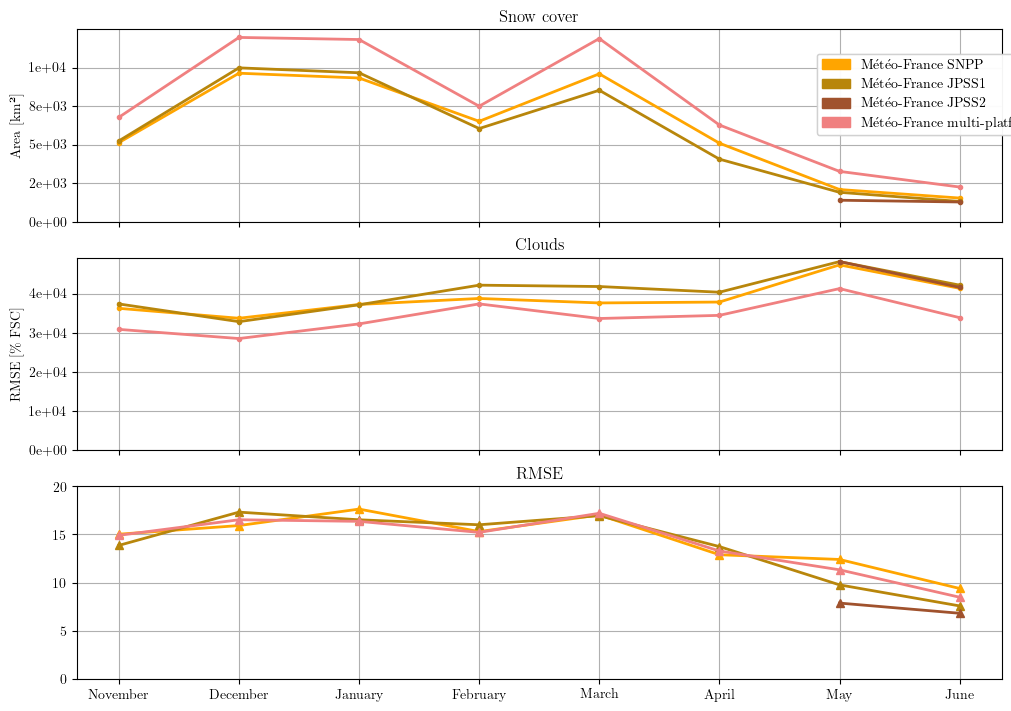

In [4]:
from products.snow_cover_product import MeteoFranceSNPPPrototype, MeteoFranceJPSS1Prototype, MeteoFranceJPSS2Prototype, MeteoFranceMultiplatformPrototype
from matplotlib import pyplot as plt

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/'
product_list = [MeteoFranceSNPPPrototype(),MeteoFranceJPSS1Prototype(),  MeteoFranceJPSS2Prototype(),MeteoFranceMultiplatformPrototype()]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.subplots_adjust(bottom=0.18)
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, layout="constrained")
annual_area_fancy_plot(snow_cover_products=product_list, analysis_folder=analysis_folder, axs=axs)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/multiplatform_composite.png', format='png',bbox_inches='tight')

In [12]:
import xarray as xr

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins'))
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum()
print(snow_cover/total*100)

<xarray.DataArray 'surface' ()> Size: 8B
array(20.56430007)
Coordinates:
    class_name  <U10 40B 'snow_cover'


In [ ]:

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(altitude_bins=slice(900,None), time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins'))
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum()
print(snow_cover/total*100)

<xarray.DataArray 'surface' ()> Size: 8B
array(31.43190877)
Coordinates:
    class_name  <U10 40B 'snow_cover'


<xarray.DataArray 'n_occurrences' (ref_bins: 4, test_bins: 98)> Size: 3kB
array([[1.764218e+06, 4.252000e+03, 3.354000e+03, 2.742000e+03,
        2.512000e+03, 2.232000e+03, 2.165000e+03, 1.949000e+03,
        1.809000e+03, 1.792000e+03, 1.752000e+03, 1.634000e+03,
        1.648000e+03, 1.614000e+03, 1.535000e+03, 1.390000e+03,
        1.410000e+03, 1.358000e+03, 1.223000e+03, 1.188000e+03,
        1.151000e+03, 1.115000e+03, 1.043000e+03, 9.610000e+02,
        9.230000e+02, 9.810000e+02, 8.840000e+02, 8.730000e+02,
        8.210000e+02, 8.530000e+02, 7.960000e+02, 7.720000e+02,
        7.790000e+02, 7.120000e+02, 6.950000e+02, 7.310000e+02,
        7.230000e+02, 8.010000e+02, 8.420000e+02, 9.430000e+02,
        9.790000e+02, 1.101000e+03, 1.116000e+03, 1.221000e+03,
        1.326000e+03, 1.276000e+03, 1.327000e+03, 1.374000e+03,
        1.434000e+03, 1.440000e+03, 1.428000e+03, 1.431000e+03,
        1.365000e+03, 1.391000e+03, 1.454000e+03, 1.416000e+03,
        1.382000e+03, 1.296000

<>:67: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:67: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_34617/2389545613.py:67: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_ylabel("S2 FSC [\%]")
/tmp/ipykernel_34617/2389545613.py:68: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_xlabel("VNP10A1 NDSI [\%]")


<Figure size 640x480 with 0 Axes>

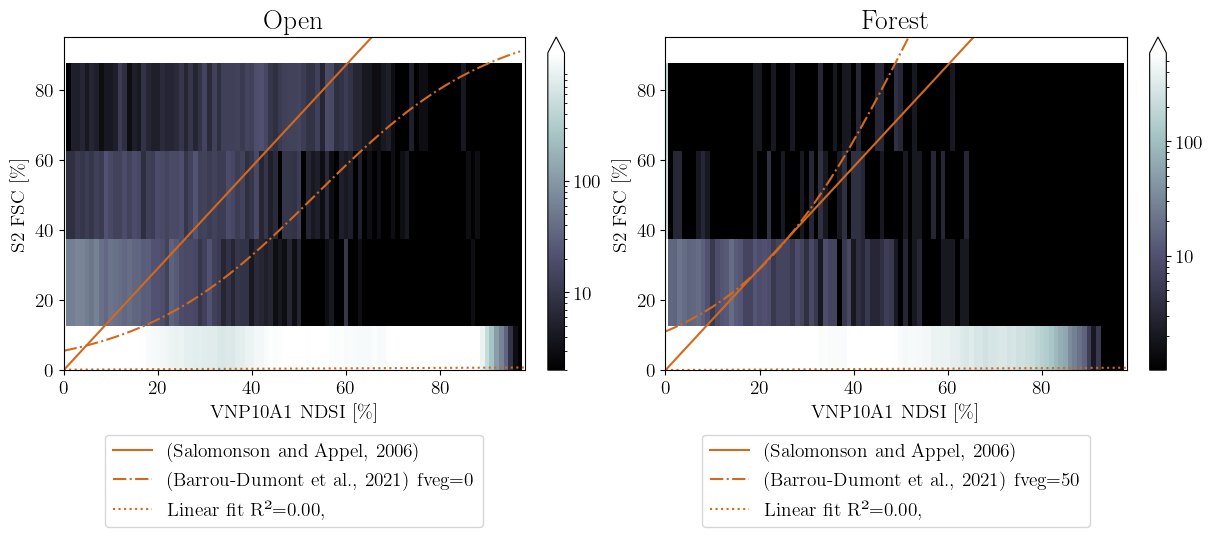

In [ ]:

### NDSI-FSC regression
from matplotlib.axes import Axes
from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot
import xarray as xr
import matplotlib.pyplot as plt


analysis_type = "scatter"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/"
)
nasa_l3_snpp_metrics_ds = xr.open_dataset(
    f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_S2_theia.nc", decode_cf=True
)
nasa_l3_snpp_metrics_ds = nasa_l3_snpp_metrics_ds.where(nasa_l3_snpp_metrics_ds > 0, drop=True)

# plt.rcParams["font.family"] = "Noto Sans"
# font = {'family' : 'Sans Serif',
#         'weight' : 'normal',
#         'size'   : 20}

# matplotlib.rc('font', **font)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

plt.subplots_adjust(bottom=0.18)
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharex=True, layout="constrained")


# ax[0].set_facecolor('#222')
FOREST_TITLE = {'no_forest': 'Open', 'forest': 'Forest'}
for i, fore in enumerate(["no_forest", "forest"]):

    n_min = 0
    # fig.suptitle("Scatter plot VIIRS NDSI_Snow_Cover vs S2 FSC")
    reduced = (
        nasa_l3_snpp_metrics_ds.sel(
            altitude_bins=slice(900,None),
            ref_bins=slice(0, 95),
            forest_mask_bins=[fore],
            test_bins=slice(0, 100),
        )
        .sum(dim=("forest_mask_bins", "time", "altitude_bins"))
        .data_vars["n_occurrences"]
    )

    xax = reduced.test_bins.values
    f_veg=0 if fore=="no_forest" else 0.5
    fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
    ax[i].plot(xax, salomonson_appel(xax), color="chocolate", linewidth=1.5, label="(Salomonson and Appel, 2006)")
    ax[i].plot(xax, fit_g,"-.",color="chocolate", linewidth=1.5, label=f"(Barrou-Dumont et al., 2021)  fveg={int(f_veg*100)}%")

    scatter_plot = fancy_scatter_plot(
        data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
        ax=ax[i],
        figure=fig,
        low_threshold=n_min,
        smoothing_window_size=0,
    )
    # ax[i].set_title(PRODUCT_PLOT_NAMES[k])
    ax[i].set_ylabel("S2 FSC [\%]")
    ax[i].set_xlabel("VNP10A1 NDSI [\%]")
    ax[i].set_title(FOREST_TITLE[fore], fontsize=20)
    ax[i].set_ylim(0,95)
    ax[i].set_xlim(0,98)


plt.show()

fig.patch.set_alpha(0.0)
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/scatter_plot.png', format='png',bbox_inches='tight')

In [8]:
import pandas as pd
from postprocess.error_distribution import histograms_to_biais_rmse
from postprocess.skill_scores import compute_all_scores
def compute_unc_results_df(metrics_dict):
    reduced_datasets = []
    for dataset in metrics_dict.values():
        reduced_datasets.append(histograms_to_biais_rmse(dataset.groupby('time.month').sum()))
    concatenated = xr.concat(reduced_datasets, pd.Index([prod.plot_name for prod in product_list], name="product"), coords="minimal")
    reduced_df = concatenated.to_dataframe().reset_index('product')
    return reduced_df

def compute_conf_results_df(metrics_dict):
    reduced_datasets = []
    for dataset in metrics_dict.values():
        tp, tn, fp, fn = (
            dataset.data_vars["true_positive"].sum(),
            dataset.data_vars["true_negative"].sum(),
            dataset.data_vars["false_positive"].sum(),
            dataset.data_vars["false_negative"].sum(),
        )
        scores = compute_all_scores(dataset.groupby('time.month').sum())
        scores = scores.assign({'total_count': tp+tn+fp+fn})
        reduced_datasets.append(scores)

    concatenated = xr.concat(reduced_datasets, pd.Index([prod.plot_name for prod in product_list], name="product"), coords="minimal")
    reduced_df = concatenated.to_dataframe().reset_index('product')
    return reduced_df